# GPU Check

In [ ]:
import GPUtil
GPUs = GPUtil.getGPUs()
for gpu in GPUs:
  print(gpu.name, gpu.memoryTotal)

# Imports

In [1]:
from search_eval.utils.common_utils import *
from search_eval.eval_SGLDES import Eval_SGLD_ES, SingleImageDataset
from search_space.unet import UNet

from nni.retiarii.evaluator.pytorch import Lightning, Trainer
from nni.retiarii.evaluator.pytorch.lightning import DataLoader

import numpy as np
import torch
torch.cuda.empty_cache()

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print('CUDA available: {}'.format(torch.cuda.is_available()))

CUDA available: True


# Execute -- SGLDES (No Search)

In [ ]:
# INPUTS

# Non HPO inputs
total_iterations = 1200
show_every = 100 #200
report_every = 25 #25

# HPO inputs
#  note a smaller learning rate affecs the SGLD, so overfitting happens FASTER at LOWER learning rates (start with 0.01)
learning_rate = .1 # 0.1089
buffer_size = 100# 500
patience = 100# 100
weight_decay= 5e-8 # 5.0e-8

resolution = 64
noise_level = 0.09
noise_type = 'gaussian'
phantom_num = np.random.randint(0, 50) # 45

phantom = np.load(f'phantoms/ground_truth/{resolution}/{phantom_num}.npy')
phantom_noisy= np.load(f'phantoms/{noise_type}/res_{resolution}/nl_{noise_level}/p_{phantom_num}.npy')

# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=64, pretrained=False)
# model = model = DeepImagePrior(in_channels=1, out_channels=1, depth=5)
model = UNet(in_channels=1, out_channels=1, init_features=64, depth=4)

print(f"\n\n----------------------------------")
print(f'Experiment Configuration:')
print(f'\tTotal Iterations: {total_iterations}')

print(f'\tPatience: {patience}')
print(f'\tBuffer Size: {buffer_size}')
print(f'\tLearning Rate: {learning_rate}')
print(f'\tWeight Decay: {weight_decay}')

print(f'\tImage Resolution: {resolution}')
print(f'\tPlotting every {show_every} iterations')
print(f"----------------------------------\n\n")

# Create the lightning module
module = Eval_SGLD_ES(
                phantom=phantom, 
                phantom_noisy=phantom_noisy,

                learning_rate=learning_rate, 
                buffer_size=buffer_size,
                patience=patience,
                weight_decay=weight_decay,
                
                report_every=report_every,
                show_every=show_every,
                model=model,
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=total_iterations,
            fast_dev_run=False,
            gpus=1,
            )
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=None)
lightning.fit(model)


### previous config
# ----------------------------------
# Experiment Configuration:
# 	Total Iterations: 1400
# 	Patience: 200
# 	Buffer Size: 500
# 	Learning Rate: 0.08
# 	Weight Decay: 5e-08
# 	Image Resolution: 64
# 	Plotting every 200 iterations
# ----------------------------------

### new config
# ----------------------------------
# learning_rate = 0.08
# patience = 200
# buffer_size = 500
# weight_decay=5e-8

# SGLD (No Search)

In [ ]:
from search_eval.eval_SGLD import Eval_SGLD
# INPUTS

# Non HPO inputs
total_iterations = 1200
show_every = 100 #200
report_every = 25 #25

# HPO inputs
#  note a smaller learning rate affecs the SGLD, so overfitting happens FASTER at LOWER learning rates (start with 0.01)
learning_rate = .1 # 0.1089
burnin_iter = 700
weight_decay= 5e-8 # 5.0e-8

resolution = 64
noise_level = 0.09
noise_type = 'gaussian'
phantom_num = np.random.randint(0, 50) # 45

phantom = np.load(f'phantoms/ground_truth/{resolution}/{phantom_num}.npy')
phantom_noisy= np.load(f'phantoms/{noise_type}/res_{resolution}/nl_{noise_level}/p_{phantom_num}.npy')

# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=64, pretrained=False)
# model = model = DeepImagePrior(in_channels=1, out_channels=1, depth=5)
model = UNet(in_channels=1, out_channels=1, init_features=64, depth=4)

print(f"\n\n----------------------------------")
print(f'Experiment Configuration:')
print(f'\tTotal Iterations: {total_iterations}')

print(f'\tPatience: {patience}')
print(f'\tBuffer Size: {buffer_size}')
print(f'\tLearning Rate: {learning_rate}')
print(f'\tWeight Decay: {weight_decay}')

print(f'\tImage Resolution: {resolution}')
print(f'\tPlotting every {show_every} iterations')
print(f"----------------------------------\n\n")

# Create the lightning module
module = Eval_SGLD(
                 phantom=phantom, 
                 phantom_noisy=phantom_noisy,

                 lr=learning_rate,
                 burnin_iter=burnin_iter, 
                 weight_decay=weight_decay,

                 MCMC_iter=50,
                 report_every=report_every,
                 show_every=show_every,
                 model=model, 
                 HPO=False
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=total_iterations,
            fast_dev_run=False,
            gpus=1,
            )
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=None)
lightning.fit(model)


### previous config
# ----------------------------------
# Experiment Configuration:
# 	Total Iterations: 1400
# 	Patience: 200
# 	Buffer Size: 500
# 	Learning Rate: 0.08
# 	Weight Decay: 5e-08
# 	Image Resolution: 64
# 	Plotting every 200 iterations
# ----------------------------------

### new config
# ----------------------------------
# learning_rate = 0.08
# patience = 200
# buffer_size = 500
# weight_decay=5e-8

# UNet no search

In [ ]:
from search_eval.eval_generic import SGLDES
from search_space.unet import UNet
# INPUTS

# Non HPO inputs
total_iterations = 1200
show_every = 100 #200
report_every = 10 #25

# HPO inputs
#  note a smaller learning rate affecs the SGLD, so overfitting happens FASTER at LOWER learning rates (start with 0.01)
learning_rate = .1 # 0.1089
buffer_size = 200# 500
patience = 250# 100
weight_decay= 5e-8 # 5.0e-8

resolution = 64
noise_level = 0.09
noise_type = 'gaussian'
phantom_num = np.random.randint(0, 50) # 45

phantom = np.load(f'phantoms/ground_truth/{resolution}/{phantom_num}.npy')
phantom_noisy= np.load(f'phantoms/{noise_type}/res_{resolution}/nl_{noise_level}/p_{phantom_num}.npy')

# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=64, pretrained=False)
# model = model = DeepImagePrior(in_channels=1, out_channels=1, depth=5)
model = UNet(in_channels=1, out_channels=1, init_features=64, depth=4)

print(f"\n\n----------------------------------")
print(f'Experiment Configuration:')
print(f'\tTotal Iterations: {total_iterations}')

print(f'\tPatience: {patience}')
print(f'\tBuffer Size: {buffer_size}')
print(f'\tLearning Rate: {learning_rate}')
print(f'\tWeight Decay: {weight_decay}')

print(f'\tImage Resolution: {resolution}')
print(f'\tPlotting every {show_every} iterations')
print(f"----------------------------------\n\n")

# Create the lightning module
module = SGLDES(
                 phantom=phantom, 
                 phantom_noisy=phantom_noisy,

                 learning_rate=learning_rate, 
                 buffer_size=buffer_size,
                 patience=patience,
                 weight_decay=weight_decay,
                
                 model_cls=model,
                 HPO=False,
                 NAS=False,
                 OneShot=False,
                 SGLD_regularize=False,
                 ES=False,
                 switch=None,
                 plotting=True
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=total_iterations,
            fast_dev_run=False,
            gpus=1,
            )
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
# because we are using a deep image prior the data loader is all theater
train_loader = DataLoader(SingleImageDataset(phantom_noisy, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=None)
lightning.fit(model)


### previous config
# ----------------------------------
# Experiment Configuration:
# 	Total Iterations: 1400
# 	Patience: 200
# 	Buffer Size: 500
# 	Learning Rate: 0.08
# 	Weight Decay: 5e-08
# 	Image Resolution: 64
# 	Plotting every 200 iterations
# ----------------------------------

### new config
# ----------------------------------
# learning_rate = 0.08
# patience = 200
# buffer_size = 500
# weight_decay=5e-8

# UNet Attention (no search)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs




----------------------------------
Experiment Configuration:
	Total Iterations: 1200
	Patience: 150
	Buffer Size: 200
	Learning Rate: 0.1
	Weight Decay: 5e-08
	Image Resolution: 64
	Plotting every 100 iterations
----------------------------------


[2023-09-15 02:23:50] WARNING: Validation dataloaders are missing.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model_cls | UNet    | 31.0 M
1 | criteria  | MSELoss | 0     
--------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.146   Total estimated model params size (MB)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smaller than the l

Training: 0it [00:00, ?it/s]

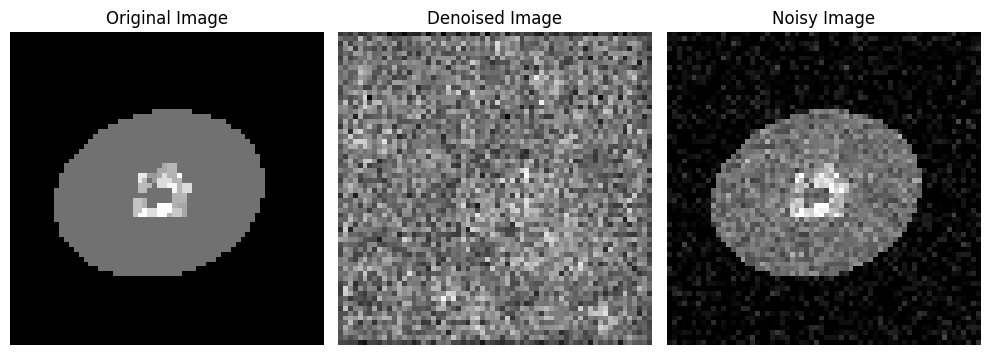

[2023-09-15 02:23:50] Intermediate result: {"iteration": 0, "loss": 0.1988, "psnr_gt": 6.54342, "var": "Pre-Burnin"}  (Index 18)
[2023-09-15 02:24:28] Intermediate result: {"iteration": 25, "loss": 0.00953, "psnr_gt": 22.77257, "var": "Pre-Burnin"}  (Index 19)
[2023-09-15 02:25:05] Intermediate result: {"iteration": 50, "loss": 0.00826, "psnr_gt": 24.20366, "var": "Pre-Burnin"}  (Index 20)
[2023-09-15 02:25:43] Intermediate result: {"iteration": 75, "loss": 0.00783, "psnr_gt": 24.50166, "var": "Pre-Burnin"}  (Index 21)
[2023-09-15 02:26:20] Intermediate result: {"iteration": 100, "loss": 0.00781, "psnr_gt": 24.36066, "var": "Pre-Burnin"}  (Index 22)
[2023-09-15 02:26:57] Intermediate result: {"iteration": 125, "loss": 0.00749, "psnr_gt": 24.50703, "var": "Pre-Burnin"}  (Index 23)
[2023-09-15 02:27:34] Intermediate result: {"iteration": 150, "loss": 0.0075, "psnr_gt": 24.5626, "var": "Pre-Burnin"}  (Index 24)
[2023-09-15 02:28:12] Intermediate result: {"iteration": 175, "loss": 0.00775,

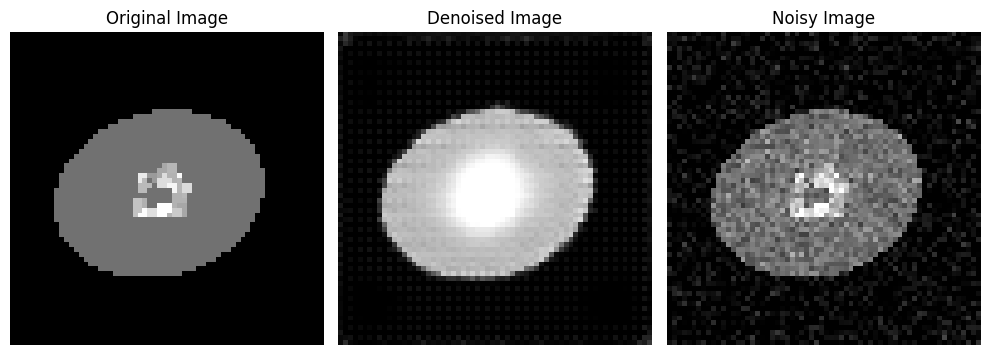

[2023-09-15 02:28:49] Intermediate result: {"iteration": 200, "loss": 0.00646, "psnr_gt": 25.46631, "var": "Pre-Burnin"}  (Index 26)
[2023-09-15 02:29:27] Intermediate result: {"iteration": 225, "loss": 0.00631, "psnr_gt": 25.83842, "var": "Pre-Burnin"}  (Index 27)
[2023-09-15 02:30:04] Intermediate result: {"iteration": 250, "loss": 0.00713, "psnr_gt": 24.46718, "var": "Pre-Burnin"}  (Index 28)
[2023-09-15 02:30:41] Intermediate result: {"iteration": 275, "loss": 0.00686, "psnr_gt": 25.07168, "var": "Pre-Burnin"}  (Index 29)
[2023-09-15 02:31:17] Intermediate result: {"iteration": 300, "loss": 0.00595, "psnr_gt": 26.56684, "var": "Pre-Burnin"}  (Index 30)
[2023-09-15 02:31:53] Intermediate result: {"iteration": 325, "loss": 0.00544, "psnr_gt": 26.94908, "var": "Pre-Burnin"}  (Index 31)
[2023-09-15 02:32:30] Intermediate result: {"iteration": 350, "loss": 0.00537, "psnr_gt": 26.75418, "var": "Pre-Burnin"}  (Index 32)
[2023-09-15 02:33:06] Intermediate result: {"iteration": 375, "loss":

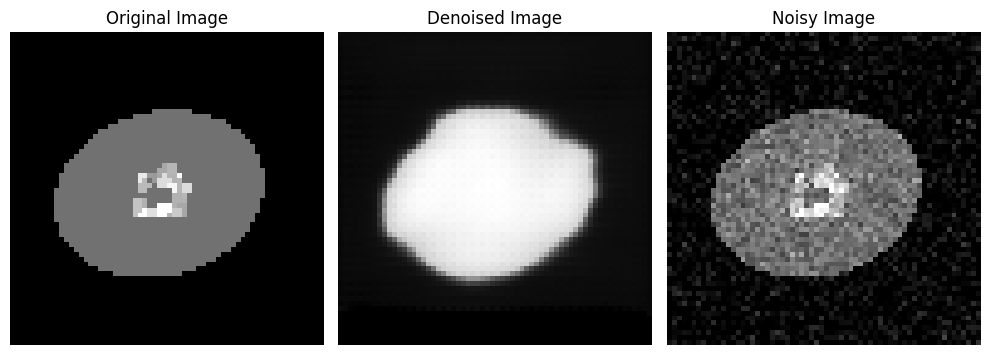

[2023-09-15 02:33:43] Intermediate result: {"iteration": 400, "loss": 0.00821, "psnr_gt": 22.98589, "var": "Pre-Burnin"}  (Index 34)
[2023-09-15 02:34:19] Intermediate result: {"iteration": 425, "loss": 0.00667, "psnr_gt": 24.48404, "var": "Pre-Burnin"}  (Index 35)
[2023-09-15 02:34:56] Intermediate result: {"iteration": 450, "loss": 0.00619, "psnr_gt": 25.01425, "var": "Pre-Burnin"}  (Index 36)
[2023-09-15 02:35:32] Intermediate result: {"iteration": 475, "loss": 0.00599, "psnr_gt": 25.61174, "var": "Pre-Burnin"}  (Index 37)
[2023-09-15 02:36:08] Intermediate result: {"iteration": 500, "loss": 0.00556, "psnr_gt": 26.12466, "var": "Pre-Burnin"}  (Index 38)
[2023-09-15 02:36:45] Intermediate result: {"iteration": 525, "loss": 0.00548, "psnr_gt": 25.92762, "var": "Pre-Burnin"}  (Index 39)
[2023-09-15 02:37:21] Intermediate result: {"iteration": 550, "loss": 0.00532, "psnr_gt": 26.5506, "var": "Pre-Burnin"}  (Index 40)
[2023-09-15 02:37:57] Intermediate result: {"iteration": 575, "loss": 

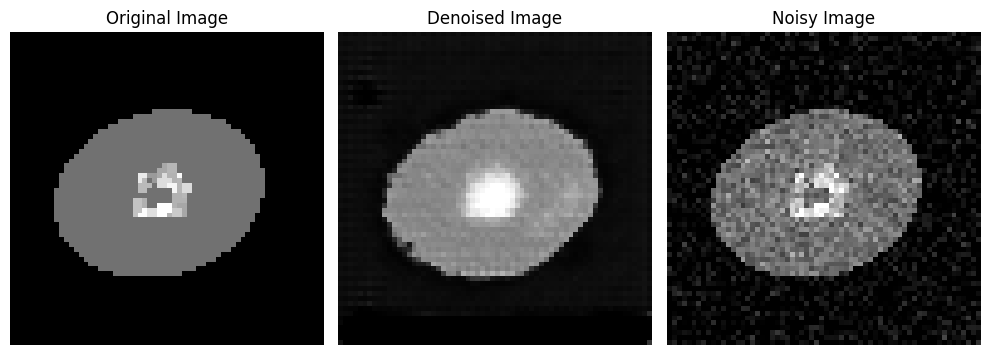

[2023-09-15 02:38:34] Intermediate result: {"iteration": 600, "loss": 0.00823, "psnr_gt": 22.6827, "var": "Pre-Burnin"}  (Index 42)
[2023-09-15 02:39:10] Intermediate result: {"iteration": 625, "loss": 0.00488, "psnr_gt": 26.63019, "var": "Pre-Burnin"}  (Index 43)
[2023-09-15 02:39:46] Intermediate result: {"iteration": 650, "loss": 0.00469, "psnr_gt": 26.32277, "var": "Pre-Burnin"}  (Index 44)
[2023-09-15 02:40:22] Intermediate result: {"iteration": 675, "loss": 0.00441, "psnr_gt": 26.00897, "var": "Pre-Burnin"}  (Index 45)
[2023-09-15 02:40:58] Intermediate result: {"iteration": 700, "loss": 0.00289, "psnr_gt": 25.85277, "var": "Pre-Burnin"}  (Index 46)
[2023-09-15 02:41:34] Intermediate result: {"iteration": 725, "loss": 0.00172, "psnr_gt": 23.5718, "var": "Pre-Burnin"}  (Index 47)
[2023-09-15 02:42:10] Intermediate result: {"iteration": 750, "loss": 0.00128, "psnr_gt": 23.6584, "var": "Pre-Burnin"}  (Index 48)
[2023-09-15 02:42:47] Intermediate result: {"iteration": 775, "loss": 0.

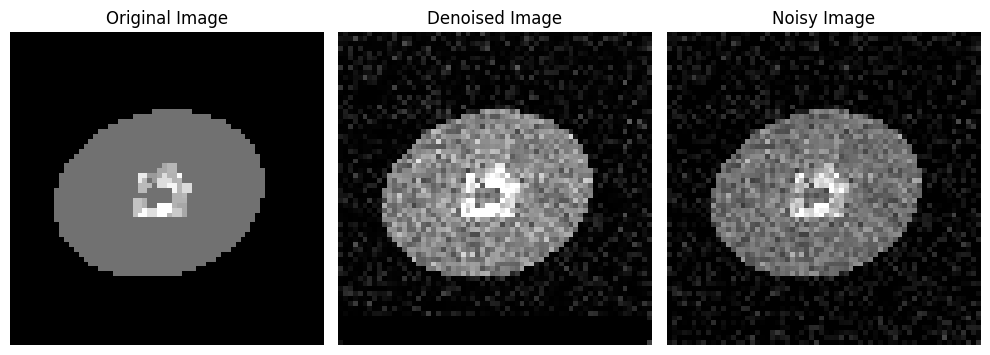

[2023-09-15 02:43:23] Intermediate result: {"iteration": 800, "loss": 0.00068, "psnr_gt": 23.43486, "var": "Pre-Burnin"}  (Index 50)
[2023-09-15 02:43:59] Intermediate result: {"iteration": 825, "loss": 0.0083, "psnr_gt": 23.05932, "var": "Pre-Burnin"}  (Index 51)
[2023-09-15 02:44:35] Intermediate result: {"iteration": 850, "loss": 0.00751, "psnr_gt": 23.6431, "var": "Pre-Burnin"}  (Index 52)
[2023-09-15 02:45:11] Intermediate result: {"iteration": 875, "loss": 0.00769, "psnr_gt": 23.24537, "var": "Pre-Burnin"}  (Index 53)
[2023-09-15 02:45:48] Intermediate result: {"iteration": 900, "loss": 0.00663, "psnr_gt": 24.57625, "var": "Pre-Burnin"}  (Index 54)
[2023-09-15 02:46:24] Intermediate result: {"iteration": 925, "loss": 0.00684, "psnr_gt": 24.13181, "var": "Pre-Burnin"}  (Index 55)
[2023-09-15 02:47:00] Intermediate result: {"iteration": 950, "loss": 0.00633, "psnr_gt": 24.501, "var": "Pre-Burnin"}  (Index 56)
[2023-09-15 02:47:36] Intermediate result: {"iteration": 975, "loss": 0.0

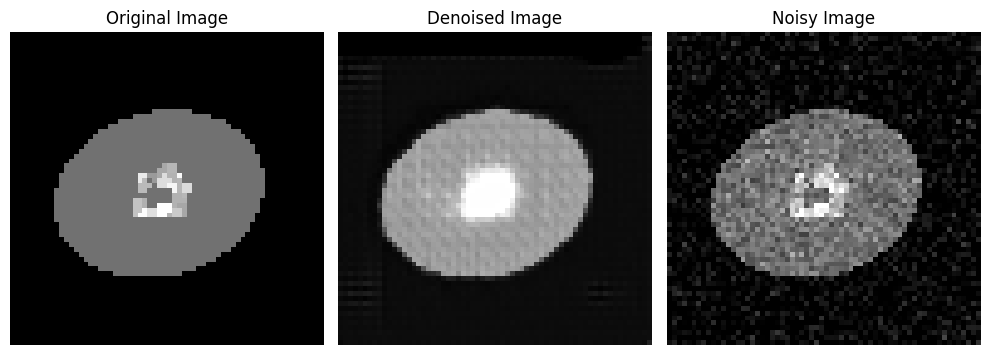

[2023-09-15 02:48:13] Intermediate result: {"iteration": 1000, "loss": 0.00532, "psnr_gt": 26.05129, "var": "Pre-Burnin"}  (Index 58)
[2023-09-15 02:48:49] Intermediate result: {"iteration": 1025, "loss": 0.00499, "psnr_gt": 26.71967, "var": "Pre-Burnin"}  (Index 59)
[2023-09-15 02:49:25] Intermediate result: {"iteration": 1050, "loss": 0.00632, "psnr_gt": 24.90248, "var": "Pre-Burnin"}  (Index 60)
[2023-09-15 02:50:01] Intermediate result: {"iteration": 1075, "loss": 0.00458, "psnr_gt": 27.34601, "var": "Pre-Burnin"}  (Index 61)
[2023-09-15 02:50:37] Intermediate result: {"iteration": 1100, "loss": 0.00412, "psnr_gt": 27.04687, "var": "Pre-Burnin"}  (Index 62)
[2023-09-15 02:51:13] Intermediate result: {"iteration": 1125, "loss": 0.00342, "psnr_gt": 26.76803, "var": "Pre-Burnin"}  (Index 63)
[2023-09-15 02:51:50] Intermediate result: {"iteration": 1150, "loss": 0.00373, "psnr_gt": 26.6235, "var": "Pre-Burnin"}  (Index 64)
[2023-09-15 02:52:25] Intermediate result: {"iteration": 1175, 

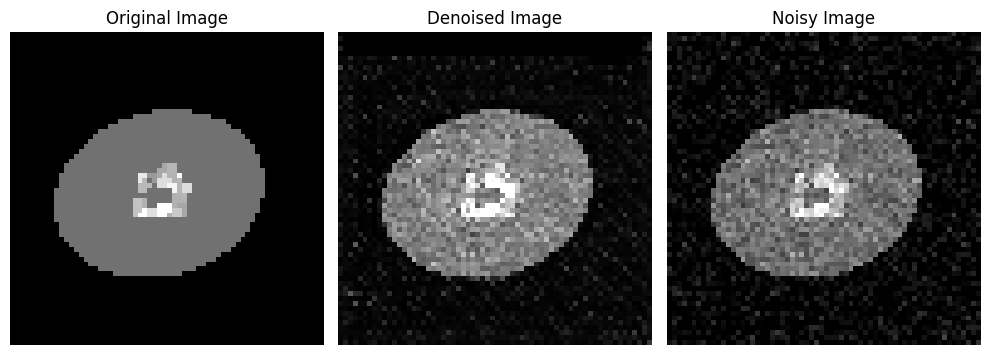

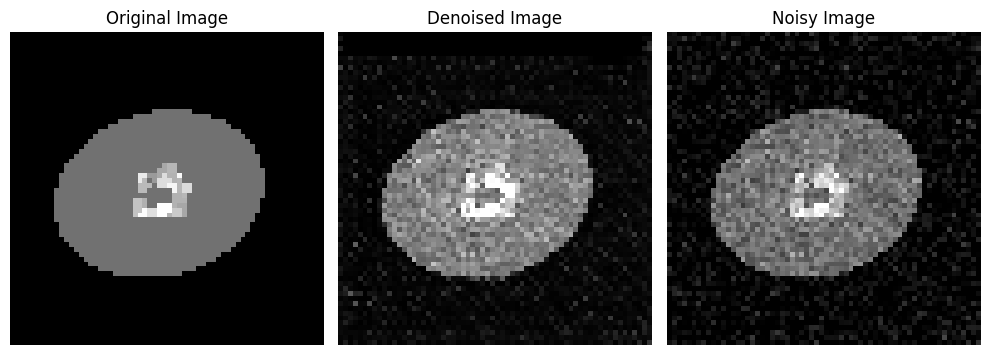

Final PSNR: 24.93689
[2023-09-15 02:53:02] Final result: 24.93689


In [3]:
from search_eval.eval_generic import SGLDES
from search_space.unetAttention import UNetAttention
# INPUTS

# Non HPO inputs
total_iterations = 1200
show_every = 100 #200
report_every = 10 #25

# HPO inputs
#  note a smaller learning rate affecs the SGLD, so overfitting happens FASTER at LOWER learning rates (start with 0.01)
learning_rate = .1 # 0.1089
buffer_size = 200# 500
patience = 150# 100
weight_decay= 5e-8 # 5.0e-8

resolution = 64
noise_level = 0.09
noise_type = 'gaussian'
phantom_num = np.random.randint(0, 50) # 45

phantom = np.load(f'phantoms/ground_truth/{resolution}/{phantom_num}.npy')
phantom_noisy= np.load(f'phantoms/{noise_type}/res_{resolution}/nl_{noise_level}/p_{phantom_num}.npy')

# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=64, pretrained=False)
# model = model = DeepImagePrior(in_channels=1, out_channels=1, depth=5)
model = UNet(in_channels=1, out_channels=1, init_features=64, depth=4)

print(f"\n\n----------------------------------")
print(f'Experiment Configuration:')
print(f'\tTotal Iterations: {total_iterations}')

print(f'\tPatience: {patience}')
print(f'\tBuffer Size: {buffer_size}')
print(f'\tLearning Rate: {learning_rate}')
print(f'\tWeight Decay: {weight_decay}')

print(f'\tImage Resolution: {resolution}')
print(f'\tPlotting every {show_every} iterations')
print(f"----------------------------------\n\n")

# Create the lightning module
module = SGLDES(
                 phantom=phantom, 
                 phantom_noisy=phantom_noisy,

                 learning_rate=learning_rate, 
                 buffer_size=buffer_size,
                 patience=patience,
                 weight_decay=weight_decay,
                
                 model_cls=model,
                 HPO=False,
                 NAS=False,
                 OneShot=False,
                 SGLD_regularize=False,
                 ES=False,
                 switch=None,
                 plotting=True
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=total_iterations,
            fast_dev_run=False,
            gpus=1,
            )
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=None)
lightning.fit(model)


### previous config
# ----------------------------------
# Experiment Configuration:
# 	Total Iterations: 1400
# 	Patience: 200
# 	Buffer Size: 500
# 	Learning Rate: 0.08
# 	Weight Decay: 5e-08
# 	Image Resolution: 64
# 	Plotting every 200 iterations
# ----------------------------------

### new config
# ----------------------------------
# learning_rate = 0.08
# patience = 200
# buffer_size = 500
# weight_decay=5e-8